In [27]:
# Import libraries
import torch
import torch.nn as nn
from torch import optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split, Subset

# A module to print a model summary (outputs shape, number of parameters, ...)
import torchsummary

# TensorBoard for visualization
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
# plt.rcParams['text.usetex'] = True  # Render Matplotlib text with Tex
from PIL import Image
from sklearn.model_selection import train_test_split
import time

import cv2

## Prepare data

In [42]:
# Define the data to be used
DATASET = "../../datasets/dataset_3+8bags_3var3sc_regression_classification_kmeans_split/"


class TraversabilityDataset(Dataset):
    """Custom Dataset class to represent our dataset
    It includes data and information about the data

    Args:
        Dataset (class): Abstract class which represents a dataset
    """
    
    def __init__(self, traversal_costs_file, images_directory,
                 transform=None):
        """Constructor of the class

        Args:
            traversal_costs_file (string): Path to the csv file which contains
            images index and their associated traversal cost
            images_directory (string): Directory with all the images
            transform (callable, optional): Transforms to be applied on a
            sample. Defaults to None.
        """
        # Read the csv file
        self.traversal_costs_frame = pd.read_csv(traversal_costs_file)
        
        # Initialize the name of the images directory
        self.images_directory = images_directory
        
        # Initialize the transforms
        self.transform = transform

    def __len__(self):
        """Return the size of the dataset

        Returns:
            int: Number of samples
        """
        # Count the number of files in the image directory
        # return len(os.listdir(self.images_directory))
        return len(self.traversal_costs_frame)

    def __getitem__(self, idx):
        """Allow to access a sample by its index

        Args:
            idx (int): Index of a sample

        Returns:
            list: Sample at index idx
            ([image, traversal_cost])
        """
        # Get the image name at index idx
        image_name = os.path.join(self.images_directory,
                                  self.traversal_costs_frame.loc[idx, "image_id"])
        
        # Read the image
        image = Image.open(image_name)
        
        # Eventually apply transforms to the image
        if self.transform:
            image = self.transform(image)
        
        # Get the corresponding traversal cost
        traversal_cost = self.traversal_costs_frame.loc[idx, "traversal_cost"]
        
        # Get the corresponding traversability label
        traversability_label = self.traversal_costs_frame.loc[idx, "traversability_label"]

        return image, traversal_cost, traversability_label

In [43]:
def compute_mean_std(images_directory, traversal_costs_file):
    transform = transforms.Compose([
        # Reduce the size of the images
        # (if size is an int, the smaller edge of the
        # image will be matched to this number and the ration is kept)
        transforms.Resize((70, 210)),

        # Convert a PIL Image or numpy.ndarray to tensor
        transforms.ToTensor(),
    ])
    
    # Create a Dataset for training
    dataset = TraversabilityDataset(
        traversal_costs_file=DATASET+traversal_costs_file,
        images_directory=DATASET+images_directory,
        transform=transform
    )
    
    loader = DataLoader(
        dataset=dataset,
        batch_size=1,
        shuffle=False,
        num_workers=12,
        pin_memory=True
    )

    cnt = 0
    first_moment = torch.empty(3)
    second_moment = torch.empty(3)

    for images, traversal_costs, traversability_labels in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
        first_moment = (cnt * first_moment + sum_) / (cnt + nb_pixels)
        second_moment = (cnt * second_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels

    mean = first_moment
    std = torch.sqrt(second_moment - first_moment ** 2)
    
    return mean, std

In [44]:
mean, std = compute_mean_std("images_train", "traversal_costs_train.csv")
print(mean, std)

tensor([0.3426, 0.3569, 0.2914]) tensor([0.1363, 0.1248, 0.1302])


In [45]:
# Compose several transforms together to be applied to training data
# (Note that transforms are not applied yet)
train_transform = transforms.Compose([
    # Reduce the size of the images
    # (if size is an int, the smaller edge of the
    # image will be matched to this number and the ration is kept)
    # transforms.Resize(100),
    transforms.Resize((70, 210)),
    
    # Perform horizontal flip of the image with a probability of 0.5
    transforms.RandomHorizontalFlip(p=0.5),
    
    # Modify the brightness and the contrast of the image
    transforms.ColorJitter(contrast=0.5, brightness=0.5),
    
    # Convert a PIL Image or numpy.ndarray to tensor
    transforms.ToTensor(),
    
    # Add some random gaussian noise to the image
    transforms.Lambda(lambda x: x + (0.001**0.5)*torch.randn(x.shape)),
    
    # Normalize a tensor image with pre-computed mean and standard deviation
    # (based on the data used to train the model(s))
    # (be careful, it only works on torch.*Tensor)
    transforms.Normalize(
        mean=mean,
        std=std,
        # mean=[0.485, 0.456, 0.406],
        # std=[0.229, 0.224, 0.225],
    ),
])

# Define a different set of transforms testing
# (for instance we do not need to flip the image)
test_transform = transforms.Compose([
    # transforms.Resize(100),
    transforms.Resize((70, 210)),
    # transforms.Grayscale(),
    # transforms.CenterCrop(100),
    # transforms.RandomCrop(100),
    transforms.ToTensor(),
    
    # Mean and standard deviation were pre-computed on the training data
    # (on the ImageNet dataset)
    transforms.Normalize(
        mean=mean,
        std=std,
        # mean=[0.485, 0.456, 0.406],
        # std=[0.229, 0.224, 0.225],
    ),
])


# # Create a Dataset instance for our training data
# data = TraversabilityDataset(
#     traversal_costs_file=DATASET+"traversal_costs.csv",
#     images_directory=DATASET+"images",
#     transform=train_transform
# )

# # Split our training dataset into a training dataset and a validation dataset
# train_set, val_set, test_set = random_split(data, [0.8, 0.1, 0.1])


# Create a Dataset for training
train_set = TraversabilityDataset(
    traversal_costs_file=DATASET+"traversal_costs_train.csv",
    images_directory=DATASET+"images_train",
    transform=train_transform
)

# Create a Dataset for validation
val_set = TraversabilityDataset(
    traversal_costs_file=DATASET+"traversal_costs_train.csv",
    images_directory=DATASET+"images_train",
    transform=test_transform
)

# Create a Dataset for testin
test_set = TraversabilityDataset(
    traversal_costs_file=DATASET+"traversal_costs_test.csv",
    images_directory=DATASET+"images_test",
    transform=test_transform
)

# Set the train dataset size
# 70% of the total data is used for training, 15% for validation
# and 15% for testing
train_size = 70/(100-15)

# Splits train data indices into train and validation data indices
train_indices, val_indices = train_test_split(range(len(train_set)), train_size=train_size)

# Extract the corresponding subsets of the train dataset
train_set = Subset(train_set, train_indices)
val_set = Subset(val_set, val_indices)


BATCH_SIZE = 32

# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

val_loader = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,  # SequentialSampler
    num_workers=12,
    pin_memory=True,
)

In [46]:
# Get the number of samples per split
NB_TRAIN = len(train_set)
NB_VAL = len(val_set)
NB_TEST = len(test_set)

In [47]:
# Display the splits ratio
NB_SAMPLES = NB_TRAIN + NB_VAL + NB_TEST

print(f"{np.round(NB_TRAIN/NB_SAMPLES*100)} % of the data for training ({NB_TRAIN} samples)")
print(f"{np.round(NB_VAL/NB_SAMPLES*100)} % of the data for validation ({NB_VAL} samples)")
print(f"{np.round(NB_TEST/NB_SAMPLES*100)} % of the data for testing ({NB_TEST} samples)")

70.0 % of the data for training (6239 samples)
15.0 % of the data for validation (1337 samples)
15.0 % of the data for testing (1338 samples)


## GPU?

In [48]:
# Use a GPU if available
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cuda



## Model design and initialization

In [59]:
# Open TensorBoard
tensorboard = SummaryWriter()

# Load the pre-trained ResNet model
model = models.resnet18().to(device=device)

# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device=device)

# Replace the last layer by a fully-connected one with 1 output
model.fc = nn.Linear(model.fc.in_features, 1, device=device)

# Initialize the last layer using Xavier initialization
# nn.init.xavier_uniform_(model.fc.weight)

# Display the architecture in TensorBoard
images, traversal_costs, traversability_labels = next(iter(train_loader))
images = images.to(device)
tensorboard.add_graph(model, images)

# print(model)
# print(torchsummary.summary(model, (3, 100, 100)))

In [60]:
[(name, param.shape) for name, param in model.named_parameters()]

[('conv1.weight', torch.Size([64, 3, 7, 7])),
 ('bn1.weight', torch.Size([64])),
 ('bn1.bias', torch.Size([64])),
 ('layer1.0.conv1.weight', torch.Size([64, 64, 3, 3])),
 ('layer1.0.bn1.weight', torch.Size([64])),
 ('layer1.0.bn1.bias', torch.Size([64])),
 ('layer1.0.conv2.weight', torch.Size([64, 64, 3, 3])),
 ('layer1.0.bn2.weight', torch.Size([64])),
 ('layer1.0.bn2.bias', torch.Size([64])),
 ('layer1.1.conv1.weight', torch.Size([64, 64, 3, 3])),
 ('layer1.1.bn1.weight', torch.Size([64])),
 ('layer1.1.bn1.bias', torch.Size([64])),
 ('layer1.1.conv2.weight', torch.Size([64, 64, 3, 3])),
 ('layer1.1.bn2.weight', torch.Size([64])),
 ('layer1.1.bn2.bias', torch.Size([64])),
 ('layer2.0.conv1.weight', torch.Size([128, 64, 3, 3])),
 ('layer2.0.bn1.weight', torch.Size([128])),
 ('layer2.0.bn1.bias', torch.Size([128])),
 ('layer2.0.conv2.weight', torch.Size([128, 128, 3, 3])),
 ('layer2.0.bn2.weight', torch.Size([128])),
 ('layer2.0.bn2.bias', torch.Size([128])),
 ('layer2.0.downsample.0.we

In [61]:
print(model.fc.state_dict())

OrderedDict([('weight', tensor([[-0.0390, -0.0057, -0.0246, -0.0063, -0.0090, -0.0424, -0.0067, -0.0173,
         -0.0407,  0.0207, -0.0349,  0.0081, -0.0363,  0.0298,  0.0390,  0.0081,
         -0.0123, -0.0167,  0.0013, -0.0196, -0.0289, -0.0229, -0.0392,  0.0226,
         -0.0315,  0.0410, -0.0250,  0.0108, -0.0165,  0.0085, -0.0038, -0.0185,
         -0.0252,  0.0433, -0.0234,  0.0013, -0.0095,  0.0361, -0.0396,  0.0296,
         -0.0433, -0.0246,  0.0319,  0.0093, -0.0193,  0.0157, -0.0352,  0.0051,
          0.0274, -0.0419,  0.0054, -0.0108, -0.0040,  0.0282,  0.0160, -0.0355,
         -0.0346,  0.0407, -0.0209,  0.0158,  0.0269, -0.0441, -0.0113, -0.0129,
          0.0251,  0.0102, -0.0293,  0.0410,  0.0185, -0.0302, -0.0441, -0.0097,
         -0.0297, -0.0219,  0.0032, -0.0127, -0.0179,  0.0118,  0.0090,  0.0023,
         -0.0184,  0.0103, -0.0213,  0.0265,  0.0229, -0.0212, -0.0150,  0.0199,
          0.0062, -0.0339,  0.0184,  0.0042,  0.0305, -0.0085, -0.0101,  0.0312,
    

## Training and validation loops

In [56]:
# Define the loss function
criterion = nn.MSELoss()

# Get all the parameters excepts the weights and bias of fc layer
base_params = [param for name, param in model.named_parameters()
               if name not in ["fc.weight", "fc.bias"]]

# Define the optimizer, with a greater learning rate for the new fc layer
optimizer = optim.SGD([
    {"params": base_params},
    {"params": model.fc.parameters(), "lr": 1e-3},
],
    lr=1e-3, momentum=0.9, weight_decay=0.001)

# An epoch is one complete pass of the training dataset through the network
NB_EPOCHS = 100

# Number of epochs we wait for the loss to decrease before stopping
# the training process early
patience = 10

best_val_loss = float('inf')
best_epoch = 0

loss_values = torch.zeros(2, NB_EPOCHS)

# Loop over the epochs
for epoch in range(NB_EPOCHS):
    
    # Training
    train_loss = 0.
    
    # Configure the model for training
    # (good practice, only necessary if the model operates differently for
    # training and validation)
    model.train()
    
    # Add a progress bar
    train_loader_pbar = tqdm(train_loader, unit="batch")
    
    # Loop over the training batches
    for images, traversal_costs, _ in train_loader_pbar:
        
        # Print the epoch and training mode
        train_loader_pbar.set_description(f"Epoch {epoch} [train]")
        
        # Move images and traversal scores to GPU (if available)
        images = images.to(device)
        traversal_costs = traversal_costs.type(torch.FloatTensor).to(device)
        
        # Zero out gradients before each backpropagation pass, to avoid that
        # they accumulate
        optimizer.zero_grad()
        
        # Perform forward pass
        predicted_traversal_costs = model(images)
        
        # Compute loss 
        loss = criterion(predicted_traversal_costs[:, 0], traversal_costs)
        
        # Print the batch loss next to the progress bar
        train_loader_pbar.set_postfix(batch_loss=loss.item())
        
        # Perform backpropagation (update weights)
        loss.backward()
        
        # Adjust parameters based on gradients
        optimizer.step()
        
        # Accumulate batch loss to average over the epoch
        train_loss += loss.item()
    
    
    # Validation
    val_loss = 0.
    
    # Configure the model for testing
    # (turn off dropout layers, batchnorm layers, etc)
    model.eval()
    
    # Add a progress bar
    val_loader_pbar = tqdm(val_loader, unit="batch")
    
    # Turn off gradients computation (the backward computational graph is built during
    # the forward pass and weights are updated during the backward pass, here we avoid
    # building the graph)
    with torch.no_grad():
        # Loop over the validation batches
        for images, traversal_costs, _ in val_loader_pbar:

            # Print the epoch and validation mode
            val_loader_pbar.set_description(f"Epoch {epoch} [val]")

            # Move images and traversal scores to GPU (if available)
            images = images.to(device)
            traversal_costs = traversal_costs.type(torch.FloatTensor).to(device)
            
            # Perform forward pass (only, no backpropagation)
            predicted_traversal_costs = model(images)

            # Compute loss
            loss = criterion(predicted_traversal_costs[:, 0], traversal_costs)

            # Print the batch loss next to the progress bar
            val_loader_pbar.set_postfix(batch_loss=loss.item())

            # Accumulate batch loss to average over the epoch
            val_loss += loss.item()
            
    
    # Compute the losses
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    
    print("Train loss: ", train_loss)
    print("Validation loss: ", val_loss)
    
    # Store the computed losses
    loss_values[0, epoch] = train_loss
    loss_values[1, epoch] = val_loss
    
    # Add the losses to TensorBoard
    tensorboard.add_scalar("train_loss", train_loss, epoch)
    tensorboard.add_scalar("val_loss", val_loss, epoch)
    
    # Early stopping based on validation loss: stop the training if the
    # loss has not improved for the last 5 epochs
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
    
    elif epoch - best_epoch >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

# Close TensorBoard
tensorboard.close()

Epoch 0 [val]: 100%|██████████| 42/42 [00:01<00:00, 36.16batch/s, batch_loss=0.312] 


Train loss:  0.3429989586273829
Validation loss:  0.20681149406092508


Epoch 1 [val]: 100%|██████████| 42/42 [00:01<00:00, 35.71batch/s, batch_loss=0.165] 


Train loss:  0.1258507183729074
Validation loss:  0.13330156285138356


Epoch 2 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.82batch/s, batch_loss=0.133] 


Train loss:  0.10432854460982176
Validation loss:  0.11805094911583833


Epoch 3 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.21batch/s, batch_loss=0.0843]


Train loss:  0.08425097035673948
Validation loss:  0.09348590246268682


Epoch 4 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.62batch/s, batch_loss=0.1]   


Train loss:  0.08819914600596979
Validation loss:  0.11007757254299663


Epoch 5 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.07batch/s, batch_loss=0.0772]


Train loss:  0.0755614169419576
Validation loss:  0.09997402308952241


Epoch 6 [val]: 100%|██████████| 42/42 [00:01<00:00, 36.83batch/s, batch_loss=0.241] 


Train loss:  0.08310612740042882
Validation loss:  0.18160126163136392


Epoch 7 [val]: 100%|██████████| 42/42 [00:01<00:00, 35.15batch/s, batch_loss=0.204] 


Train loss:  0.08127168799057985
Validation loss:  0.13232906286915144


Epoch 8 [val]: 100%|██████████| 42/42 [00:01<00:00, 37.39batch/s, batch_loss=0.0695]


Train loss:  0.07813484637210003
Validation loss:  0.10233707406691142


Epoch 9 [val]: 100%|██████████| 42/42 [00:01<00:00, 37.16batch/s, batch_loss=0.159] 


Train loss:  0.07437381457823973
Validation loss:  0.09818310015613124


Epoch 10 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.74batch/s, batch_loss=0.166] 


Train loss:  0.08468710702772324
Validation loss:  0.11321851965926942


Epoch 11 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.05batch/s, batch_loss=0.067] 


Train loss:  0.07750909277834954
Validation loss:  0.08087557705030554


Epoch 12 [val]: 100%|██████████| 42/42 [00:01<00:00, 36.08batch/s, batch_loss=0.0708]


Train loss:  0.07421752988145902
Validation loss:  0.07854546100965568


Epoch 13 [val]: 100%|██████████| 42/42 [00:01<00:00, 35.74batch/s, batch_loss=0.0567]


Train loss:  0.06803052275417706
Validation loss:  0.07732757863899072


Epoch 14 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.85batch/s, batch_loss=0.076] 


Train loss:  0.06837069982519517
Validation loss:  0.0801080491039015


Epoch 15 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.05batch/s, batch_loss=0.0816]


Train loss:  0.07091262065447294
Validation loss:  0.0898172485509089


Epoch 16 [val]: 100%|██████████| 42/42 [00:01<00:00, 26.48batch/s, batch_loss=0.0992]


Train loss:  0.065859991321579
Validation loss:  0.0998790261468717


Epoch 17 [val]: 100%|██████████| 42/42 [00:01<00:00, 31.80batch/s, batch_loss=0.0777]


Train loss:  0.07159482301809848
Validation loss:  0.10858046494069554


Epoch 18 [val]: 100%|██████████| 42/42 [00:01<00:00, 32.95batch/s, batch_loss=0.103] 


Train loss:  0.07042926764832093
Validation loss:  0.07911174416187264


Epoch 19 [val]: 100%|██████████| 42/42 [00:01<00:00, 33.21batch/s, batch_loss=0.101] 


Train loss:  0.07184643620290818
Validation loss:  0.10117130549181075


Epoch 20 [val]: 100%|██████████| 42/42 [00:01<00:00, 32.55batch/s, batch_loss=0.0455]


Train loss:  0.0682264843239234
Validation loss:  0.07938419557398274


Epoch 21 [val]: 100%|██████████| 42/42 [00:01<00:00, 32.56batch/s, batch_loss=0.0509]


Train loss:  0.06850482676273738
Validation loss:  0.07409845523181416


Epoch 22 [val]: 100%|██████████| 42/42 [00:01<00:00, 35.80batch/s, batch_loss=0.104] 


Train loss:  0.06800697918694754
Validation loss:  0.08847838001591819


Epoch 23 [val]: 100%|██████████| 42/42 [00:01<00:00, 35.43batch/s, batch_loss=0.0574]


Train loss:  0.0734382274059149
Validation loss:  0.06846942708251022


Epoch 24 [val]: 100%|██████████| 42/42 [00:01<00:00, 35.09batch/s, batch_loss=0.09]  


Train loss:  0.06639070308361299
Validation loss:  0.07600275036834535


Epoch 25 [val]: 100%|██████████| 42/42 [00:01<00:00, 35.26batch/s, batch_loss=0.0424]


Train loss:  0.07295812595731173
Validation loss:  0.07015592409741311


Epoch 26 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.64batch/s, batch_loss=0.0732]


Train loss:  0.06737934086376275
Validation loss:  0.11328353448992684


Epoch 27 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.10batch/s, batch_loss=0.156] 


Train loss:  0.0715328611051425
Validation loss:  0.14158935809419268


Epoch 28 [val]: 100%|██████████| 42/42 [00:01<00:00, 32.89batch/s, batch_loss=0.0849]


Train loss:  0.06353038387038769
Validation loss:  0.09834849798963183


Epoch 29 [val]: 100%|██████████| 42/42 [00:01<00:00, 31.06batch/s, batch_loss=0.143] 


Train loss:  0.07251939942630438
Validation loss:  0.14711920367110343


Epoch 30 [val]: 100%|██████████| 42/42 [00:01<00:00, 32.65batch/s, batch_loss=0.161] 


Train loss:  0.06534375621913335
Validation loss:  0.08246614136511371


Epoch 31 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.69batch/s, batch_loss=0.118] 


Train loss:  0.06980224900807326
Validation loss:  0.1410217187589123


Epoch 32 [val]: 100%|██████████| 42/42 [00:01<00:00, 33.72batch/s, batch_loss=0.0503]


Train loss:  0.06928294440492605
Validation loss:  0.11435108303668953


Epoch 33 [val]: 100%|██████████| 42/42 [00:01<00:00, 32.20batch/s, batch_loss=0.0579]


Train loss:  0.08081208983292947
Validation loss:  0.06579285709276086


Epoch 34 [val]: 100%|██████████| 42/42 [00:01<00:00, 32.72batch/s, batch_loss=0.102] 


Train loss:  0.06473296566460378
Validation loss:  0.08629904093132132


Epoch 35 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.77batch/s, batch_loss=0.0397]


Train loss:  0.069464214060169
Validation loss:  0.0901464360455672


Epoch 36 [val]: 100%|██████████| 42/42 [00:01<00:00, 32.05batch/s, batch_loss=0.0445]


Train loss:  0.058831883976474784
Validation loss:  0.07664926979868185


Epoch 37 [val]: 100%|██████████| 42/42 [00:01<00:00, 33.48batch/s, batch_loss=0.0881]


Train loss:  0.06313194221793077
Validation loss:  0.11251153619516463


Epoch 38 [val]: 100%|██████████| 42/42 [00:01<00:00, 33.25batch/s, batch_loss=0.0286]


Train loss:  0.0608290581844556
Validation loss:  0.07112782852103312


Epoch 39 [val]: 100%|██████████| 42/42 [00:01<00:00, 34.02batch/s, batch_loss=0.0773]


Train loss:  0.06873671773534555
Validation loss:  0.0740763908695607


Epoch 40 [val]: 100%|██████████| 42/42 [00:01<00:00, 32.22batch/s, batch_loss=0.0553]


Train loss:  0.07671495154500008
Validation loss:  0.06766610033810139


Epoch 41 [val]: 100%|██████████| 42/42 [00:01<00:00, 33.26batch/s, batch_loss=0.0641]


Train loss:  0.0674519462749744
Validation loss:  0.06681363027365435


Epoch 42 [val]: 100%|██████████| 42/42 [00:01<00:00, 30.87batch/s, batch_loss=0.0667]


Train loss:  0.0613324856528869
Validation loss:  0.0709944578952023


Epoch 43 [val]: 100%|██████████| 42/42 [00:01<00:00, 31.40batch/s, batch_loss=0.0475]

Train loss:  0.06878531658305571
Validation loss:  0.08054042634155069
Early stopping at epoch 43


### Visualization

Text(0.5, 0, 'Epoch')

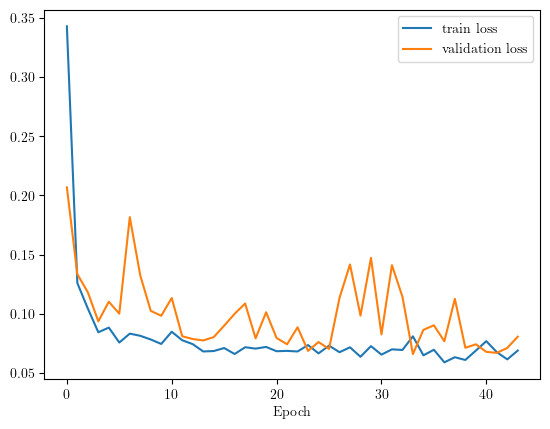

In [57]:
# Loss
indices = loss_values[0] != 0
train_losses = loss_values[0][indices]
val_losses = loss_values[1][indices]

plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="validation loss")

plt.legend()
plt.xlabel("Epoch")

## Testing

In [58]:
# Testing
test_loss = 0.

# Configure the model for testing
model.eval()

with torch.no_grad():
    # Loop over the testing batches
    for images, traversal_costs, _ in test_loader:
        
        images = images.to(device)
        traversal_costs = traversal_costs.to(device)
        
        # Perform forward pass
        predicted_traversal_costs = model(images)
        
        # Compute loss
        loss = criterion(predicted_traversal_costs[:, 0], traversal_costs)
        
        # Accumulate batch loss to average of the entire testing set
        test_loss += loss.item()
        
# Compute the loss and accuracy
test_loss /= len(test_loader)

print("Test loss: ", test_loss)

Test loss:  0.07602755005300138


In [41]:
images, traversal_costs, _ = next(iter(test_loader))

images = images.to(device)
traversal_costs = traversal_costs.to(device)

predicted_traversal_scores = model(images)
# predicted_traversal_scores = nn.Softmax(dim=1)(model(images))

print("Output:\n", predicted_traversal_costs)
print("Ground truth:\n", traversal_costs)

# print(predicted_traversal_scores-traversal_scores)

# predicted_traversal_scores = predicted_traversal_scores.to("cpu").detach().numpy()
# plt.hist(predicted_traversal_scores)


Output:
 tensor([[2.0622],
        [1.4585],
        [1.9043],
        [2.1624],
        [1.9757],
        [2.0722],
        [1.9546],
        [1.9779],
        [1.9246],
        [1.9387],
        [1.9201],
        [1.6849],
        [1.8691],
        [2.0227],
        [1.7642],
        [1.9321],
        [1.6783],
        [2.1785],
        [2.1655],
        [1.3817],
        [1.9115],
        [1.6339],
        [1.7190],
        [1.8927],
        [1.9418],
        [1.6963]], device='cuda:0')
Ground truth:
 tensor([1.4431, 1.8142, 1.4213, 1.8988, 1.6864, 1.0896, 1.3164, 1.1830, 1.9168,
        1.0740, 1.7578, 1.9497, 1.1054, 1.4927, 2.1730, 1.6349, 1.9143, 1.6020,
        1.8331, 2.0072, 1.7344, 1.1041, 1.8847, 1.4045, 0.9980, 2.2835, 1.8514,
        1.1247, 2.0487, 1.2955, 1.9082, 1.9524], device='cuda:0',
       dtype=torch.float64)


(array([  58.,  323.,  565.,  727.,  665.,  921., 1330., 1083.,  458.,
         109.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

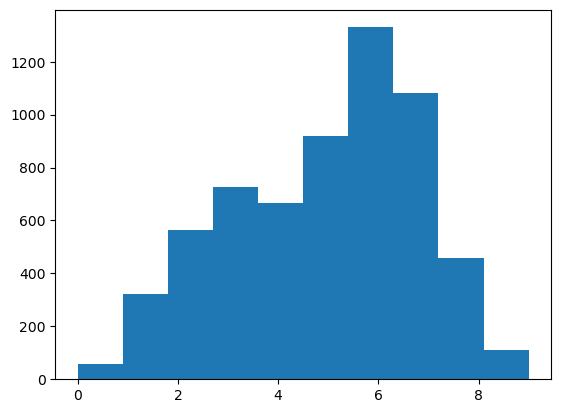

In [74]:
traversal_costs_train = []

for _, score in train_set:
    traversal_costs_train.append(score)
    
# print(traversal_scores_train)
plt.hist(traversal_costs_train, bins=10)

## Save model parameters

In [ ]:
# Save the model parameters
torch.save(model.state_dict(), "resnet18_fine_tuned_3+8bags_3var3sc_classification_kmeans_100epochs.params")